In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation,concatenate,BatchNormalization
from tensorflow.keras.layers import Input, Dense, Flatten, Add,Lambda,LeakyReLU
from tensorflow.keras.optimizers import SGD,Adam,schedules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D,MaxPooling1D,GlobalMaxPooling1D,SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.initializers import Ones, Zeros

In [2]:
from prep_data_regression import prep_data,DataGenerator,EvaDataGenerator,get_data

In [3]:
class GroupNormalization(Layer):
	def __init__(self,groups=32,axis=-1,epsilon=1e-5,center=True,scale=True,beta_initializer='zeros',gamma_initializer='ones',beta_regularizer=None,
				 gamma_regularizer=None,beta_constraint=None,gamma_constraint=None,**kwargs):
		super(GroupNormalization, self).__init__(**kwargs)
		self.supports_masking = True
		self.groups = groups
		self.axis = axis
		self.epsilon = epsilon
		self.center = center
		self.scale = scale
		self.beta_initializer = initializers.get(beta_initializer)
		self.gamma_initializer = initializers.get(gamma_initializer)
		self.beta_regularizer = regularizers.get(beta_regularizer)
		self.gamma_regularizer = regularizers.get(gamma_regularizer)
		self.beta_constraint = constraints.get(beta_constraint)
		self.gamma_constraint = constraints.get(gamma_constraint)

	def build(self, input_shape):
		dim = input_shape[self.axis]

		if dim is None:
			raise ValueError('Axis '+str(self.axis)+' of input tensor should have a defined dimension but the layer received an input with shape '+str(input_shape)+'.')

		if dim < self.groups:
			raise ValueError('Number of groups ('+str(self.groups)+') cannot be more than the number of channels ('+str(dim)+').')

		if dim % self.groups != 0:
			raise ValueError('Number of groups ('+str(self.groups)+') must be a multiple of the number of channels ('+str(dim)+').')

		self.input_spec = InputSpec(ndim=len(input_shape),axes={self.axis: dim})
		shape = (dim,)

		if self.scale:
			self.gamma = self.add_weight(shape=shape,name='gamma',initializer=self.gamma_initializer,regularizer=self.gamma_regularizer,constraint=self.gamma_constraint)
		else:
			self.gamma = None

		if self.center:
			self.beta = self.add_weight(shape=shape,name='beta',initializer=self.beta_initializer,regularizer=self.beta_regularizer,constraint=self.beta_constraint)
		else:
			self.beta = None

		self.built = True

	def call(self, inputs, **kwargs):
		input_shape = K.int_shape(inputs)
		tensor_input_shape = K.shape(inputs)

		# Prepare broadcasting shape.
		reduction_axes = list(range(len(input_shape)))
		del reduction_axes[self.axis]
		broadcast_shape = [1] * len(input_shape)
		broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
		broadcast_shape.insert(1, self.groups)

		reshape_group_shape = K.shape(inputs)
		group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
		group_axes[self.axis] = input_shape[self.axis] // self.groups
		group_axes.insert(1, self.groups)

		# reshape inputs to new group shape
		group_shape = [group_axes[0], self.groups] + group_axes[2:]
		group_shape = K.stack(group_shape)
		inputs = K.reshape(inputs, group_shape)

		group_reduction_axes = list(range(len(group_axes)))
		group_reduction_axes = group_reduction_axes[2:]

		mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
		variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)
		inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

		# prepare broadcast shape
		inputs = K.reshape(inputs, group_shape)
		outputs = inputs

		# In this case we must explicitly broadcast all parameters.
		if self.scale:
			broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
			outputs = outputs * broadcast_gamma

		if self.center:
			broadcast_beta = K.reshape(self.beta, broadcast_shape)
			outputs = outputs + broadcast_beta

		outputs = K.reshape(outputs, tensor_input_shape)

		return outputs
    

In [4]:
def CNN(inputs):
    x = Conv1D(filters= 16, kernel_size= 12, padding = 'valid', kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(inputs)
    x = GroupNormalization(groups = 4, axis = -1)(x) 
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size = 12)(x)
    x = Dropout(0.5)(x)
    #x = Conv1D(filters= 16, kernel_size= 12, padding = 'valid', kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(x)
    #x = Activation('relu')(x)
    #x = MaxPooling1D(pool_size = 12)(x)
    #x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(32,  kernel_regularizer = regularizers.l2(1e-4),bias_regularizer = regularizers.l2(1e-4))(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    return x

In [5]:
def Regression_CNN(length):

    input_shape1 = (length,1)
    cov_input = Input(shape = input_shape1,name="cov_input")
    input_layers = cov_input

    x = CNN(cov_input)
    outLayer= Dense(1, activation='linear')(x)

    model = Model(inputs=input_layers, outputs=outLayer)

    return model


In [6]:
def normalization(train_data,train_labels,valid_data,valid_labels):
    train_data = np.log(train_data+0.05)
    train_labels = np.log(train_labels)
    valid_data = np.log(valid_data+0.05)
    valid_labels = np.log(valid_labels)
    data_mean = np.mean(train_data)
    data_std  = np.std(train_data)
    label_mean = np.mean(train_labels)
    label_std  = np.std(train_labels)
    
    data_max = np.max(train_data)
    
    train_data = (train_data-data_mean)/data_std
    #train_data = train_data/data_max
    #train_data  = train_data/300
    train_labels = (train_labels-label_mean)/label_std
    
    
    
    
    valid_data  = (valid_data-data_mean)/data_std
    #valid_data    = valid_data/data_max
    #valid_data  = valid_data/300
    valid_labels = (valid_labels-label_mean)/label_std
    
    
    return data_mean,data_std,data_max,label_mean,label_std,train_data,train_labels,valid_data,valid_labels
    

In [17]:
LENGTH = 1001

In [18]:
model = Regression_CNN(LENGTH)

In [19]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov_input (InputLayer)       [(None, 1001, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 990, 16)           208       
_________________________________________________________________
group_normalization (GroupNo (None, 990, 16)           32        
_________________________________________________________________
activation (Activation)      (None, 990, 16)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 82, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 82, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1312)              0     

In [82]:
train_data,train_labels,train_id,valid_data,valid_labels,valid_id = \
prep_data('coverage_data/snu398.gt.gt.txt',5,7.8)
trainid='snu398_'

Size of dataset: 20332


In [83]:
np.min(train_labels)

0.16129032

In [84]:
data_mean,data_std,data_max,label_mean,label_std, train_x,train_y,valid_x,valid_y = normalization(train_data,train_labels,valid_data,valid_labels)

In [85]:
print(data_mean,data_std)
print(label_mean,label_std)

-1.3378935 1.4571116
1.8906846 1.6314031


In [67]:
print(data_mean,data_std)
print(label_mean,label_std)

-1.50459 1.3668648
1.8369073 1.6522043


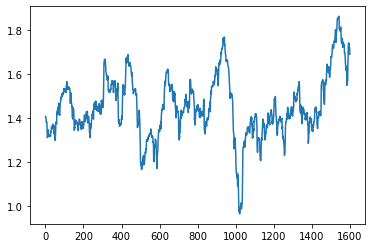

In [68]:
plt.plot(range(train_x.shape[1]),train_x[5,:,0])

In [69]:
train_y[2]

-0.6130942

In [70]:
training_generator =  DataGenerator(train_x,train_y,train_id,16,LENGTH)
validation_generator = DataGenerator(valid_x,valid_y,valid_id,0,LENGTH)

In [71]:
a,b= next(iter(training_generator))

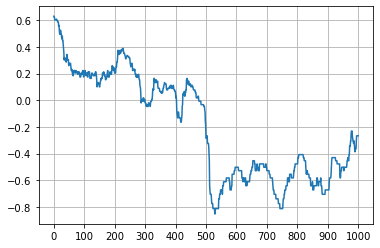

In [72]:
plt.plot(range(LENGTH),a[9])
plt.xticks(np.arange(0, LENGTH, 100))
plt.grid()
plt.show()

In [73]:
lr_schedule = schedules.ExponentialDecay(5e-4,decay_steps=5000,decay_rate=0.96)
#model.compile(loss='mean_squared_logarithmic_error', optimizer= SGD(momentum = 0.98, learning_rate = lr_schedule), metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer= SGD(momentum = 0.98, learning_rate = lr_schedule), metrics=['mse'])

In [74]:

checkpoint_path = "Regression_Model/"+trainid+"-{epoch:04d}.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1,period=10)

In [75]:
 history = model.fit(training_generator,epochs=1000,validation_data=validation_generator,callbacks=[cp_callback])

Train for 524 steps, validate for 131 steps
Epoch 1/1000
524/524 [==============================] - 4s 8ms/step - loss: 0.8349 - mse: 0.8269 - val_loss: 0.5947 - val_mse: 0.5864
Epoch 2/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.6878 - mse: 0.6795 - val_loss: 0.5924 - val_mse: 0.5841
Epoch 3/1000
524/524 [==============================] - 3s 5ms/step - loss: 0.6655 - mse: 0.6572 - val_loss: 0.5883 - val_mse: 0.5800
Epoch 4/1000
524/524 [==============================] - 3s 5ms/step - loss: 0.6487 - mse: 0.6404 - val_loss: 0.5539 - val_mse: 0.5456
Epoch 5/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.6485 - mse: 0.6402 - val_loss: 0.5308 - val_mse: 0.5225
Epoch 6/1000
524/524 [==============================] - 3s 5ms/step - loss: 0.6425 - mse: 0.6342 - val_loss: 0.5321 - val_mse: 0.5238
Epoch 7/1000
524/524 [==============================] - 3s 5ms/step - loss: 0.6284 - mse: 0.6201 - val_loss: 0.5338 - val_mse: 0.5255
Epoch 8/1000
524/5

KeyboardInterrupt: 

In [ ]:
for key in history.history.keys():
    print(key)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss of training data')
plt.plot(history.history['val_loss'], color='red', label='Loss of validation data')

In [7]:
def evaluate(x,y,pasid,MODEL_PATH,dataset,label_mean,label_std):
    test_generator = EvaDataGenerator(x,LENGTH)
    model = Regression_CNN(LENGTH)
    
    model.load_weights(MODEL_PATH)
    print('load weight success')
    pred = model.predict_generator(test_generator)
    OUT=open(dataset,'w')
    OUT.write("pas_id\tpredict\tpolyA\tpredict_rpm\tpolyA_rpm\n")
    for i in range(len(pred)):
        predict = pred[i][0]
        predict_readCount = np.exp(predict*label_std+label_mean)
        truth = y[i]
        truth_readCount   = np.exp(truth*label_std+label_mean)
        OUT.write('%s\t%s\t%s\t%s\t%s\n'%(pasid[i],predict,truth,predict_readCount,truth_readCount))
    OUT.close()

In [8]:
def standardize(train_data,train_labels,data_mean,data_std,label_mean,label_std):
    train_data = np.log(train_data+0.05)
    train_labels = np.log(train_labels)
    train_data = (train_data-data_mean)/data_std
    train_labels = (train_labels-label_mean)/label_std
    
    return train_data,train_labels
    

In [15]:
LENGTH = 1001
model = Regression_CNN(LENGTH)
trainid='snu398_'+str(LENGTH)
train_data,train_labels,train_id,valid_data,valid_labels,valid_id = \
prep_data('coverage_data/snu398.gt.gt.txt',5,7.8)
data_mean,data_std,data_max,label_mean,label_std, train_x,train_y,valid_x,valid_y = \
normalization(train_data,train_labels,valid_data,valid_labels)
#evaluate(train_x,train_y,train_id,MODEL_PATH,'train',label_mean,label_std)

Size of dataset: 20991


In [ ]:
#evaluate(valid_x,valid_y,valid_id,MODEL_PATH,'valid',label_mean,label_std)

In [16]:
bestEpoch = '0600'
MODEL_PATH = 'Regression_Model/'+trainid+'-'+str(bestEpoch)+'.ckpt'
#MODEL_PATH = '../APAIQ2/model/snu398_regression.ckpt'
train_data1,train_labels1,train_pasid1,valid_data1,valid_labels1,valid_pasid1 = \
prep_data('coverage_data/snu398.gt.gt.txt',5,7.8)
#prep_data('coverage_data/K562.predicted.txt',5,33.3)

x=np.concatenate((train_data1, valid_data1), axis=0)
y=np.concatenate((train_labels1, valid_labels1), axis=0)
pasid=np.concatenate((train_pasid1, valid_pasid1), axis=0)
#data_mean=-1.511
#data_std=1.437
#label_mean=2.473
#label_std=1.518
x,y= standardize(x,y,data_mean,data_std,label_mean,label_std)
evaluate(x,y,pasid,MODEL_PATH,'test'+str(LENGTH),label_mean,label_std)

Size of dataset: 20991
load weight success


In [ ]:
test_x.shape

In [ ]:
train_x.shape

In [ ]:
#train_data,train_labels,train_pasid,valid_data,valid_labels,valid_pasid = prep_data('coverage_data/thle2_control.pAs.usage.txt',5)
train_data,train_labels,train_pasid,valid_data,valid_labels,valid_pasid = prep_data('coverage_data/Finetune.snu398_control.usage.txt',5)
data_mean,data_std,data_max,label_mean,label_std, train_x,train_y,valid_x,valid_y = normalization(train_data,train_labels,valid_data,valid_labels)

In [ ]:
LENGTH=1001
testid='thle2.mle.linear'
bestEpoch = '0980'
evaluate(train_x,train_y,train_pasid,testid,'train',label_mean,label_std,bestEpoch)
evaluate(valid_x,valid_y,valid_pasid,testid,'valid',label_mean,label_std,bestEpoch)

In [ ]:
def evaluate1(x,y,pasid,trainid,dataset,label_mean,label_std,bestEpoch=2000):
    test_generator = EvaDataGenerator(x,LENGTH)
    model = Regression_CNN(LENGTH)
    MODEL_PATH = 'Regression_Model/'+trainid+'-'+str(bestEpoch)+'.ckpt'
    model.load_weights(MODEL_PATH)
    print('load weight success')
    pred = model.predict_generator(test_generator)
    OUT=open(dataset+'.'+trainid,'w')
    OUT.write("pas_id\tpredict\tpolyA\tpredict_readCount\tpolyA_readCount\n")
    for i in range(len(pred)):
        predict = pred[i][0]
        predict_readCount = np.exp(predict*label_std+label_mean)-1
        truth = y[i]
        truth_readCount   = np.exp(truth*label_std+label_mean)-1
        OUT.write('%s\t%s\t%s\t%s\t%s\n'%(pasid[i],predict,truth,predict_readCount,truth_readCount))
    OUT.close()

In [40]:
train_data1,train_labels1,train_pasid1,valid_data1,valid_labels1,valid_pasid1 = prep_data('coverage_data/all.snu398_control.usage.txt',5)
x=np.concatenate((train_data1, valid_data1), axis=0)
y=np.concatenate((train_labels1, valid_labels1), axis=0)
pasid=np.concatenate((train_pasid1, valid_pasid1), axis=0)
x,y= standardize(x,y,data_mean,data_std,label_mean,label_std)

TypeError: prep_data() missing 1 required positional argument: 'depth'

In [ ]:
LENGTH=1001
testid='Regression.f_snu398.shift16.1001'
bestEpoch = '2000'
evaluate1(x,y,pasid,testid,'all',label_mean,label_std,bestEpoch)

In [ ]:
np.concatenate((train_pasid1, valid_pasid1), axis=0).shape

In [ ]:
train_labels.shape

In [ ]:
data1,labels,pasid = get_data('usage_data/BL6_REP1.pAs.predict.coverage.txt')

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5,random_state=len(labels)+1,shuffle=True)

In [ ]:
folds = list(kf.split(labels))
train_index,valid_index = folds[0]

In [ ]:
OUT=open('test','w')
OUT.write("RNA_readCount\n")
for coverage in valid_data:
    mean = np.mean(coverage)
    OUT.write('%s\n'%(mean))
    #for i in coverage:
     #   OUT.write('%s\n'%(i[0]))
OUT.close()

In [ ]:
train_data[0][0]

In [ ]:
np.min(train_x)

In [ ]:
a=[3,4,5,6]
a.remove(3)
a

In [ ]:
if(a == None):
    print('fafa')

In [ ]:
a = 'chromosme,start,end,score,id,strand\n'

In [ ]:
b,c,d = a.split(',')[0:3]

In [ ]:
np.zeros(3)